# RL w/ Verifiable Rewards Experiments
Default to left-to-right arithmetic with shared helpers in `rlvr_math.py`.

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import torch
from rlvr_math import (
    DEFAULT_MODEL_ID,
    TaskConfig,
    TrainConfig,
    measure_baseline_accuracy,
    train_grpo_integer_math,
    load_trainer_logs,
    load_mem_log,
    plot_losses,
    plot_memory,
    summarize_logs,
)

logging.basicConfig(level=logging.INFO, format="%(message)s")

USE_4BIT = False  # start simple
DTYPE = torch.float32  # for compat w/ GRPO framework :/

task_cfg = TaskConfig(
    task_mode="ltr",
    ltr_min_steps=3,
    ltr_max_steps=4,
    val_range=999,
    mul_range=20,
)

eval_seed = 123


### Baseline accuracy (matches training task)
Using left-to-right arithmetic to keep evaluation aligned with the RL task.

In [5]:
baseline = measure_baseline_accuracy(
    model_id=DEFAULT_MODEL_ID,
    task_cfg=task_cfg,
    n_eval=50,
    device="cuda",
    dtype=DTYPE,
    load_in_4bit=USE_4BIT,
    eval_seed=eval_seed,
)
baseline

We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
{
  "model": "Qwen/Qwen3-0.6B",
  "task_mode": "ltr",
  "n": 50,
  "accuracy": 0.24,
  "samples": [
    {
      "problem": "Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-454 - -779 + 718 - 846\nWhat is the result?",
      "gold": 197,
      "raw": "-454 - (-779) + 718 - 846 = 718 - 846 = -128\n\n-128",
      "pred": -128,
      "ok": false
    },
    {
      "problem": "Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-319 - -302 * -17 * -10\nWhat is the result?",
      "gold": -2890,
      "raw": "-319 - (-302) * (-17) * (-10) = -319 + 302 * 17 * 10 = -319 + 5134 = 5115\n\nThe result is 5115.",
      "pred": 5115,
      "ok": false
    },
    {
      "problem": "Evaluate this expression strictly from left to right 

{'model': 'Qwen/Qwen3-0.6B',
 'task_mode': 'ltr',
 'n': 50,
 'accuracy': 0.24,
 'samples': [{'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-454 - -779 + 718 - 846\nWhat is the result?',
   'gold': 197,
   'raw': '-454 - (-779) + 718 - 846 = 718 - 846 = -128\n\n-128',
   'pred': -128,
   'ok': False},
  {'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-319 - -302 * -17 * -10\nWhat is the result?',
   'gold': -2890,
   'raw': '-319 - (-302) * (-17) * (-10) = -319 + 302 * 17 * 10 = -319 + 5134 = 5115\n\nThe result is 5115.',
   'pred': 5115,
   'ok': False},
  {'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n438 - -497 * -10 - -996\nWhat is the result?',
   'gold': -8354,
   'raw': '438 - -497 = 935  \n935 * -10 = -9350  \n-9350 - -996 = -9350 + 996 = -8354\n\nThe result is -8354.',
   'pred': -8354,
   'ok': True},
  {'prob

### GRPO training
Defaults target the LTR task with concise logging and quick-run sizing.

In [3]:
cfg = TrainConfig(
    model_id=DEFAULT_MODEL_ID,
    task=task_cfg,
    train_seed=42,
    eval_seed=eval_seed,
    quick_run=True,
    run_name="grpo-math-quick",
    output_dir="qwen3-06b-grpo-math-quick",
    logging_steps=5,
    load_in_4bit=USE_4BIT,
    dtype=DTYPE,
)

trainer = train_grpo_integer_math(cfg)

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

`torch_dtype` is deprecated! Use `dtype` instead!
We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
[mem] start used=4.73GiB free=27.12GiB total=31.84GiB reserved=2.91GiB
/home/jan/miniconda3/envs/torch312/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.006300,0.006765
100,0.010300,0.011592
150,0.008700,0.008443
200,0.002800,0.006212
250,0.011900,0.006076
300,0.003900,0.007134
350,0.006100,0.007641
400,0.004200,0.008440


[mem][step 5] used=6.02GiB (18%) step_t=8.03s tok/s~510 seq/s~8.0 ETA~52m53s
[log][step 5] loss=-0.0069 reward=0.150 ema=0.067 adv~0.150 kl=0.0000
[mem][step 10] used=6.02GiB (18%) step_t=7.85s tok/s~522 seq/s~8.2 ETA~50m59s
[log][step 10] loss=0.0024 reward=0.138 ema=0.085 adv~0.137 kl=0.0002
[mem][step 15] used=6.02GiB (18%) step_t=7.76s tok/s~528 seq/s~8.2 ETA~49m49s
[log][step 15] loss=-0.0123 reward=0.117 ema=0.086 adv~0.115 kl=0.0013
[mem][step 20] used=6.02GiB (18%) step_t=7.66s tok/s~535 seq/s~8.4 ETA~48m29s
[log][step 20] loss=0.0004 reward=0.087 ema=0.051 adv~0.080 kl=0.0074
[mem][step 25] used=6.02GiB (18%) step_t=7.49s tok/s~547 seq/s~8.5 ETA~46m50s
[log][step 25] loss=0.0030 reward=0.125 ema=0.136 adv~0.115 kl=0.0101
[mem][step 30] used=6.02GiB (18%) step_t=7.47s tok/s~548 seq/s~8.6 ETA~46m5s
[log][step 30] loss=-0.0140 reward=0.167 ema=0.243 adv~0.147 kl=0.0202
[mem][step 35] used=6.02GiB (18%) step_t=7.42s tok/s~552 seq/s~8.6 ETA~45m8s
[log][step 35] loss=-0.0009 reward=

### Training diagnostics

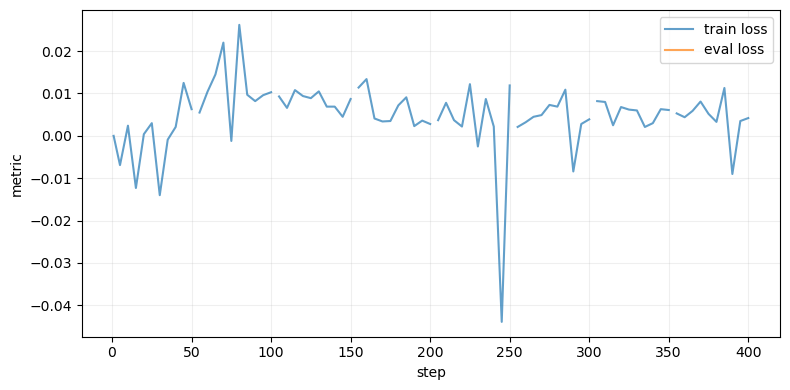

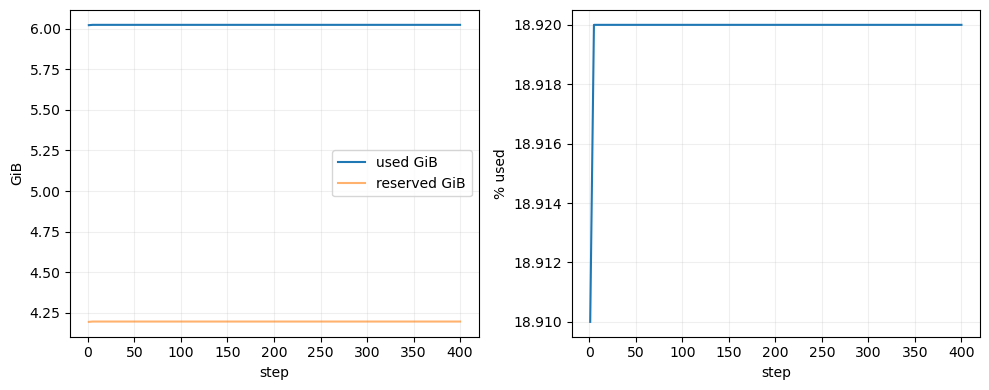

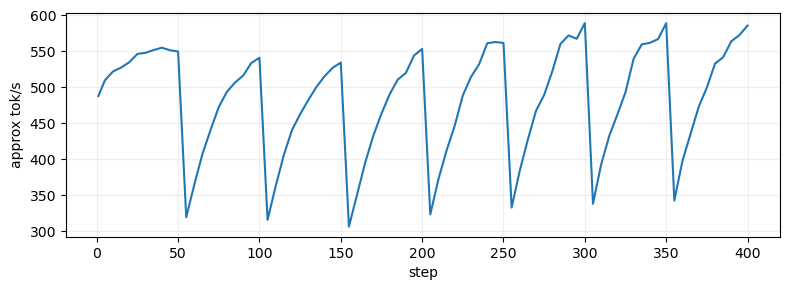

/home/jan/workspace/transformer-experiments/rlvr_math.py:809: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  out["final_train_loss"] = float(pd.to_numeric(df["loss"], errors="coerce").dropna().tail(1))
{
  "final_train_loss": 0.0042,
  "best_eval_loss": 0.006075602490454912,
  "peak_used_gib": 6.023,
  "mean_tok_s": 491.83677777777774
}


{'final_train_loss': 0.0042,
 'best_eval_loss': 0.006075602490454912,
 'peak_used_gib': 6.023,
 'mean_tok_s': 491.83677777777774}

In [4]:
df = load_trainer_logs(cfg.output_dir)
dfm = load_mem_log(cfg.output_dir)
plot_losses(df)
plot_memory(dfm)
summarize_logs(df, dfm)

In [ ]:
from transformers import AutoTokenizer
from rlvr_math import evaluate_model_accuracy

tok_ft = AutoTokenizer.from_pretrained(cfg.model_id, trust_remote_code=True)
rlvr_eval = evaluate_model_accuracy(
    model=trainer.model,
    tok=tok_ft,
    task_cfg=task_cfg,
    n_eval=100,
    device=cfg.device,
    max_new_tokens=cfg.max_completion_tok,
    eval_seed=eval_seed,
)
rlvr_eval
